# Standard 적용

[Test] acc=0.8385, auc=0.9202
CM:
 [[44 11]
 [10 65]]
              precision    recall  f1-score   support

           0     0.8148    0.8000    0.8073        55
           1     0.8553    0.8667    0.8609        75

    accuracy                         0.8385       130
   macro avg     0.8350    0.8333    0.8341       130
weighted avg     0.8382    0.8385    0.8383       130



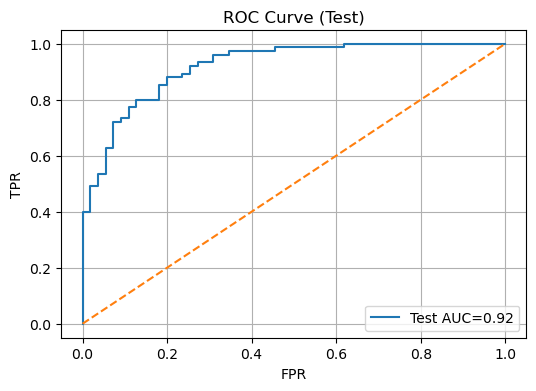

In [5]:
# mlp_finetune_evaluation.py
# Fusion Embedding 기반 MLP 학습 및 평가 전체 파이프라인 (Jupyter 환경용)

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_curve, auc
)
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler

# ▪ 설정
DATA_ROOT       = Path("embbeding_data")
AGG_METHOD      = "max"  # "mean" / "max" / "flatten"
DEVICE          = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE      = 64
LR              = 1e-4
WEIGHT_DECAY    = 1e-4
RETRAIN_EPOCHS  = 50
EARLY_STOP      = 5
SAVE_DIR        = Path("fusion_images"); SAVE_DIR.mkdir(exist_ok=True)

# ▪ 데이터 로드 및 정렬 함수
def load_split_aligned(split, model):
    base = DATA_ROOT / model / split
    emb  = np.load(base / "embeddings.npy")
    lbl  = np.load(base / "labels.npy").ravel()
    ids  = np.load(base / "ids.npy", allow_pickle=True).ravel()
    return emb, lbl, ids

def reduce_stgcn(arr):
    if AGG_METHOD == "mean":   return np.nanmean(arr, axis=1)
    if AGG_METHOD == "max":    return np.nanmax(arr, axis=1)
    if AGG_METHOD == "flatten":return arr.reshape(arr.shape[0], -1)
    raise ValueError

def align_by_ids(emb1, ids1, emb2, ids2):
    idx_map = {id_: i for i, id_ in enumerate(ids2)}
    idxs = [idx_map[id_] for id_ in ids1]
    return emb2[idxs]

# ▪ Split 별 TS/ST 로드 및 정렬
X_ts_tr, y_tr, ids_ts_tr = load_split_aligned("train",   "timesformer")
X_st_tr, _,    ids_st_tr = load_split_aligned("train",   "stgcnpp")
X_ts_va, y_va, ids_ts_va = load_split_aligned("valid",   "timesformer")
X_st_va, _,    ids_st_va = load_split_aligned("valid",   "stgcnpp")
X_ts_te, y_te, ids_ts_te = load_split_aligned("test",    "timesformer")
X_st_te, _,    ids_st_te = load_split_aligned("test",    "stgcnpp")

X_st_tr = reduce_stgcn(align_by_ids(X_ts_tr, ids_ts_tr, X_st_tr, ids_st_tr))
X_st_va = reduce_stgcn(align_by_ids(X_ts_va, ids_ts_va, X_st_va, ids_st_va))
X_st_te = reduce_stgcn(align_by_ids(X_ts_te, ids_ts_te, X_st_te, ids_st_te))

X_tr_raw = np.concatenate([X_ts_tr, X_st_tr], axis=1).astype(np.float32)
X_va_raw = np.concatenate([X_ts_va, X_st_va], axis=1).astype(np.float32)
X_te_raw = np.concatenate([X_ts_te, X_st_te], axis=1).astype(np.float32)

# ▪ 정규화
scaler = StandardScaler().fit(np.vstack([X_tr_raw, X_va_raw]))
X_tr_scaled = scaler.transform(X_tr_raw)
X_va_scaled = scaler.transform(X_va_raw)
X_te_scaled = scaler.transform(X_te_raw)

X_trva = np.vstack([X_tr_scaled, X_va_scaled])
y_trva = np.concatenate([y_tr, y_va], axis=0)

# ▪ 모델 정의
class HeadMLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 2)
        )
    def forward(self, x):
        return self.net(x)

# ▪ 학습 함수
def train_mlp(X, y):
    model = HeadMLP(X.shape[1]).to(DEVICE)
    opt   = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    crit  = nn.CrossEntropyLoss(label_smoothing=0.1)
    ds = TensorDataset(torch.from_numpy(X), torch.from_numpy(y))
    dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    best_loss, patience = float('inf'), 0
    for epoch in range(1, RETRAIN_EPOCHS+1):
        model.train(); running = 0.0
        for xb, yb in dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad(); out = model(xb)
            loss = crit(out, yb); loss.backward(); opt.step()
            running += loss.item() * yb.size(0)
        avg = running / len(ds)
        if avg < best_loss:
            best_loss, patience = avg, 0
            best_state = model.state_dict()
        else:
            patience += 1
            if patience >= EARLY_STOP: break
    model.load_state_dict(best_state)
    return model

# ▪ 평가 함수
def evaluate(model, X, y, title):
    model.eval()
    with torch.no_grad():
        probs = torch.softmax(model(torch.from_numpy(X).to(DEVICE)), 1)[:,1].cpu().numpy()
    preds = (probs > 0.5).astype(int)
    acc = accuracy_score(y, preds)
    fpr, tpr, _ = roc_curve(y, probs)
    auc_val = auc(fpr, tpr)
    print(f"{title} acc={acc:.4f}, auc={auc_val:.4f}")
    print("CM:\n", confusion_matrix(y, preds))
    print(classification_report(y, preds, digits=4))
    return fpr, tpr, auc_val

# ▪ 메인 흐름: train+valid로 학습, test로 평가
model = train_mlp(X_trva, y_trva)
fpr_te, tpr_te, auc_te = evaluate(model, X_te_scaled, y_te, "[Test]")

# ▪ 시각화 저장
plt.figure(figsize=(6,4))
plt.plot(fpr_te, tpr_te, label=f"Test AUC={auc_te:.2f}")
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curve (Test)")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.grid()
plt.savefig(SAVE_DIR/"roc_test_only.png")
plt.show()


# N-fold

[KFold-1] Valid acc=0.8615, auc=0.9439
CM:
 [[ 79  19]
 [ 13 120]]
              precision    recall  f1-score   support

           0     0.8587    0.8061    0.8316        98
           1     0.8633    0.9023    0.8824       133

    accuracy                         0.8615       231
   macro avg     0.8610    0.8542    0.8570       231
weighted avg     0.8614    0.8615    0.8608       231



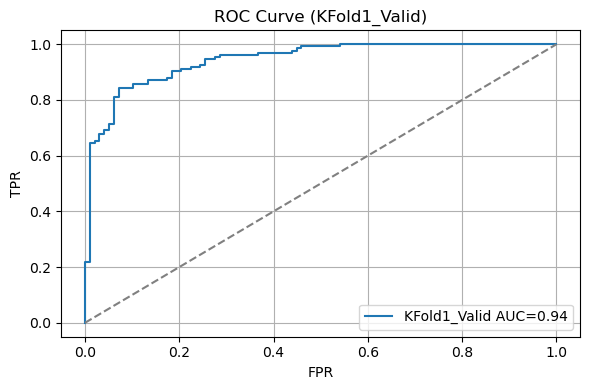

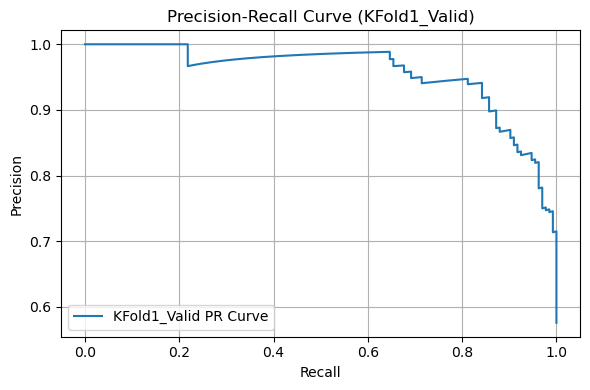

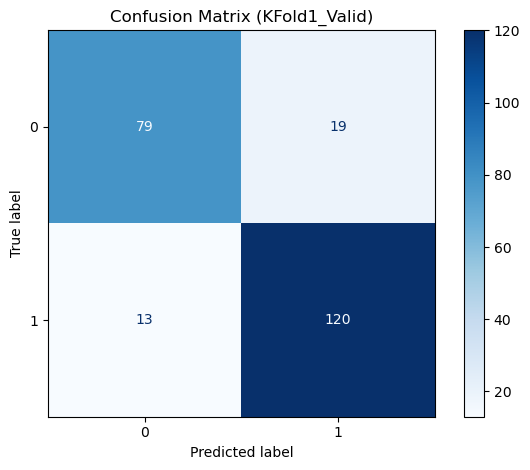

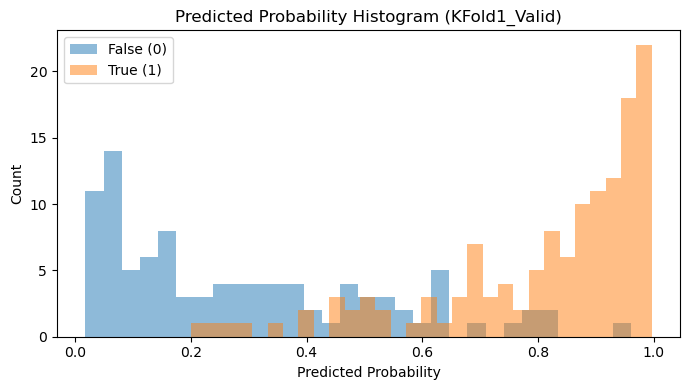

[KFold-2] Valid acc=0.8615, auc=0.9188
CM:
 [[ 84  14]
 [ 18 115]]
              precision    recall  f1-score   support

           0     0.8235    0.8571    0.8400        98
           1     0.8915    0.8647    0.8779       133

    accuracy                         0.8615       231
   macro avg     0.8575    0.8609    0.8589       231
weighted avg     0.8626    0.8615    0.8618       231



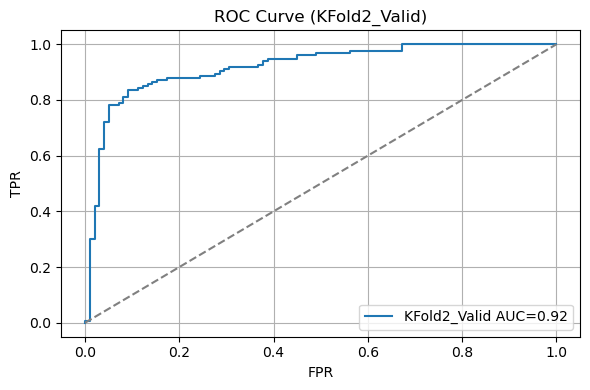

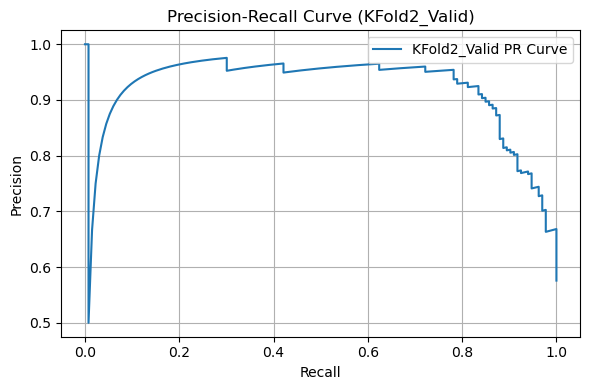

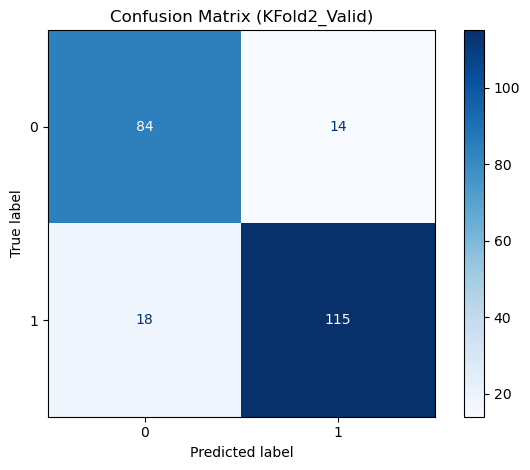

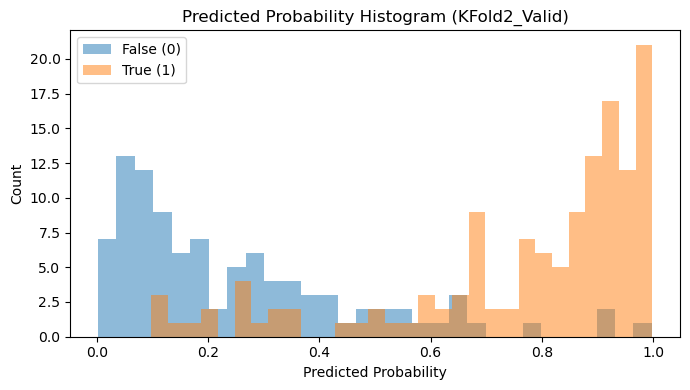

[KFold-3] Valid acc=0.8398, auc=0.8963
CM:
 [[ 80  18]
 [ 19 114]]
              precision    recall  f1-score   support

           0     0.8081    0.8163    0.8122        98
           1     0.8636    0.8571    0.8604       133

    accuracy                         0.8398       231
   macro avg     0.8359    0.8367    0.8363       231
weighted avg     0.8401    0.8398    0.8399       231



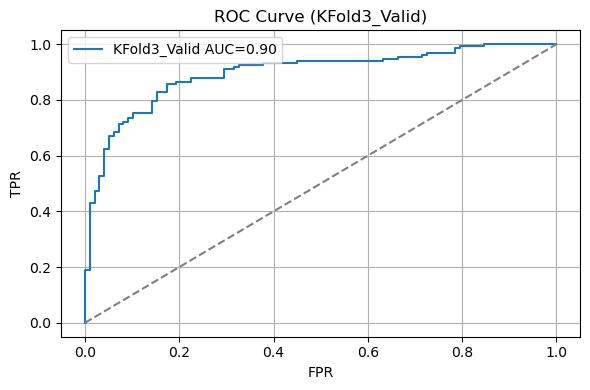

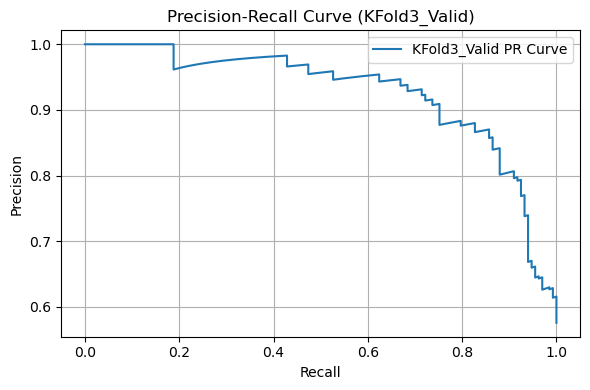

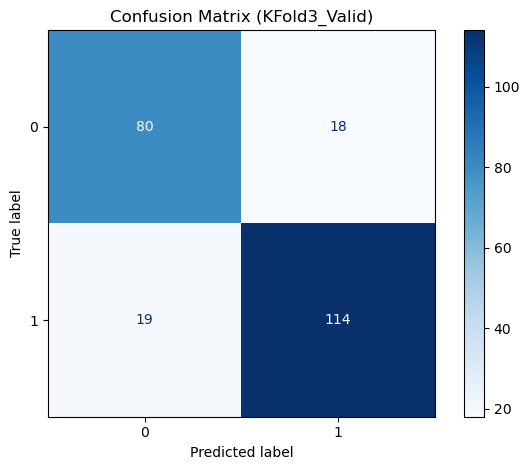

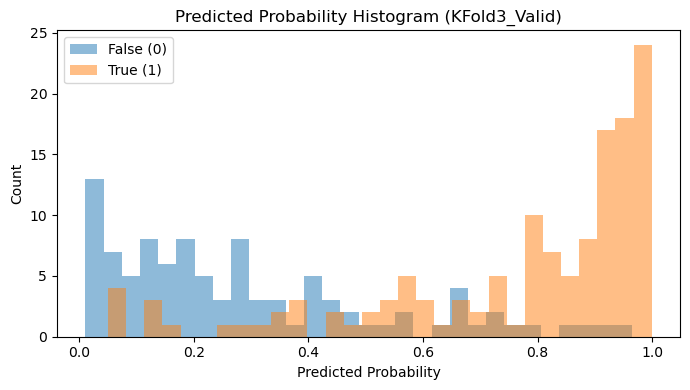

[KFold-4] Valid acc=0.8391, auc=0.9025
CM:
 [[ 80  18]
 [ 19 113]]
              precision    recall  f1-score   support

           0     0.8081    0.8163    0.8122        98
           1     0.8626    0.8561    0.8593       132

    accuracy                         0.8391       230
   macro avg     0.8353    0.8362    0.8357       230
weighted avg     0.8394    0.8391    0.8392       230



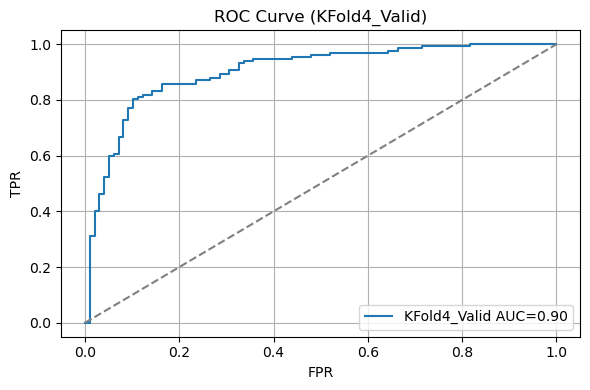

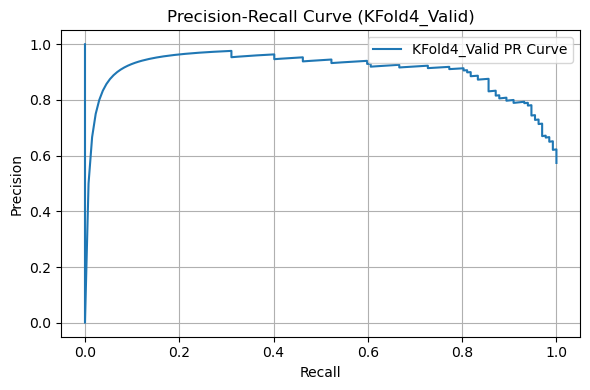

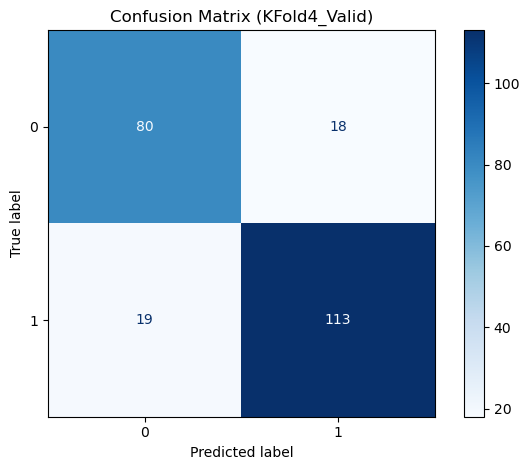

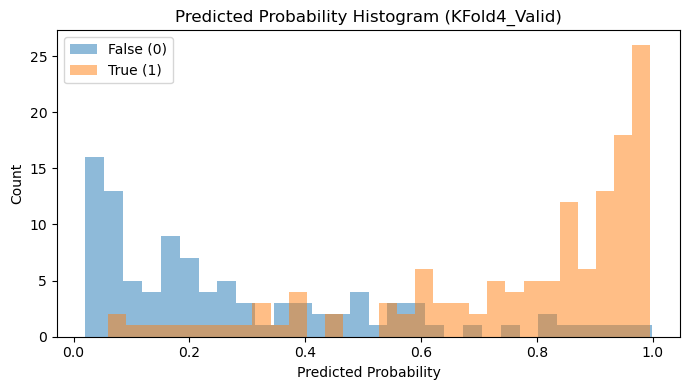

[KFold-5] Valid acc=0.8261, auc=0.9180
CM:
 [[ 80  18]
 [ 22 110]]
              precision    recall  f1-score   support

           0     0.7843    0.8163    0.8000        98
           1     0.8594    0.8333    0.8462       132

    accuracy                         0.8261       230
   macro avg     0.8218    0.8248    0.8231       230
weighted avg     0.8274    0.8261    0.8265       230



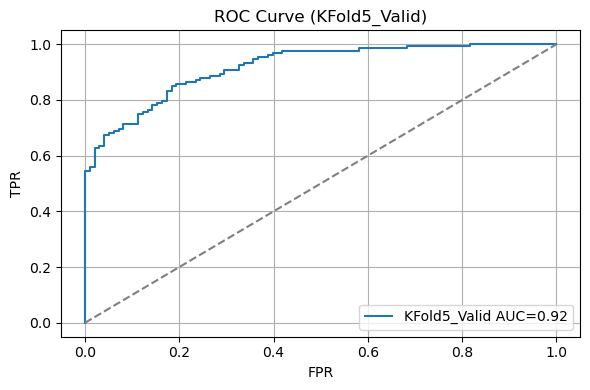

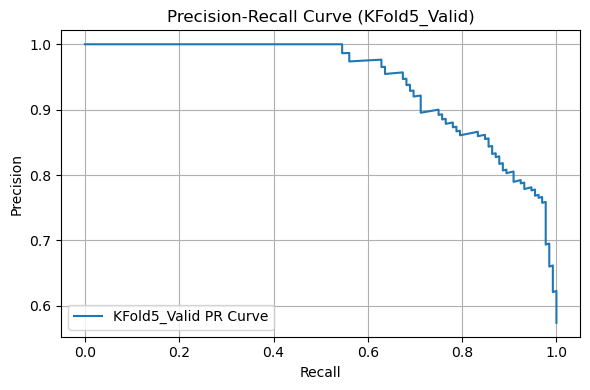

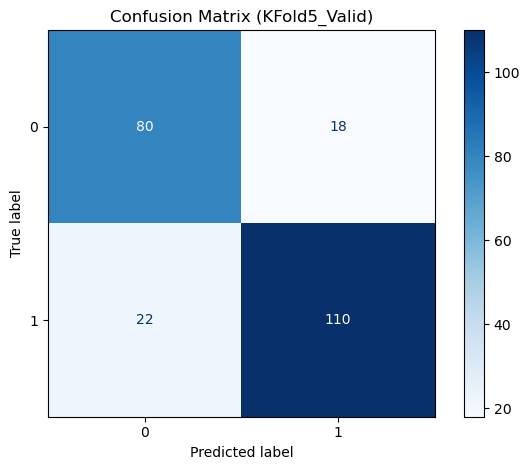

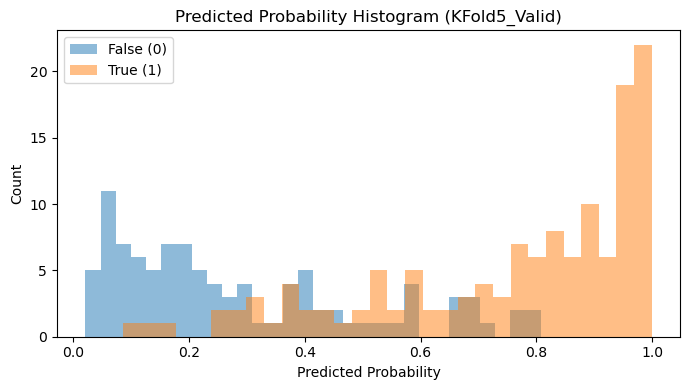


[KFold] 평균 AUC: 0.9159 / 평균 Acc: 0.8456
[Test] acc=0.8538, auc=0.9234
CM:
 [[47  8]
 [11 64]]
              precision    recall  f1-score   support

           0     0.8103    0.8545    0.8319        55
           1     0.8889    0.8533    0.8707        75

    accuracy                         0.8538       130
   macro avg     0.8496    0.8539    0.8513       130
weighted avg     0.8557    0.8538    0.8543       130



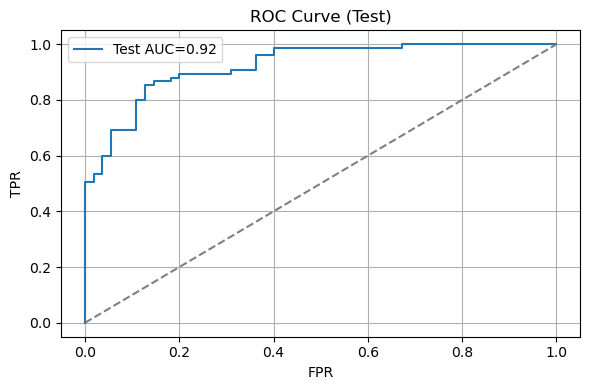

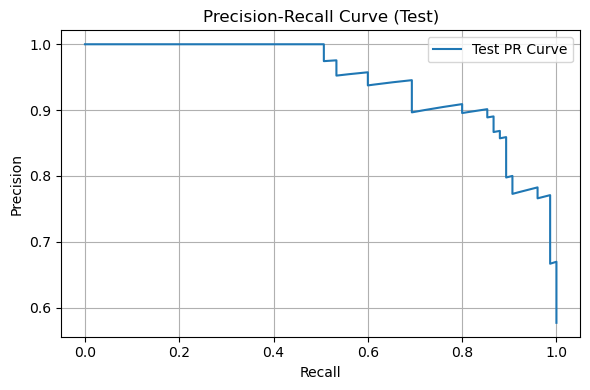

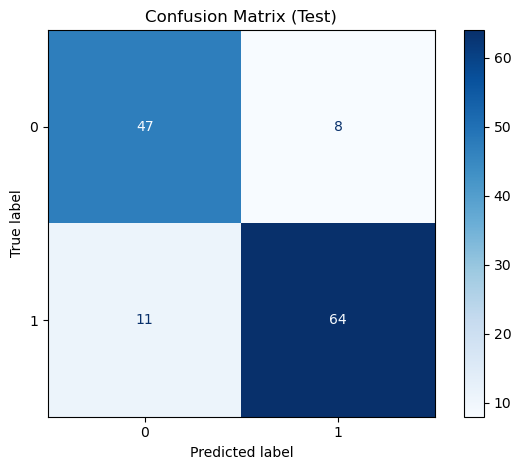

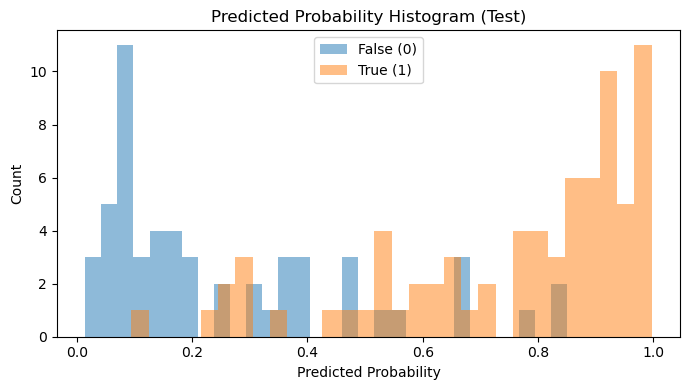

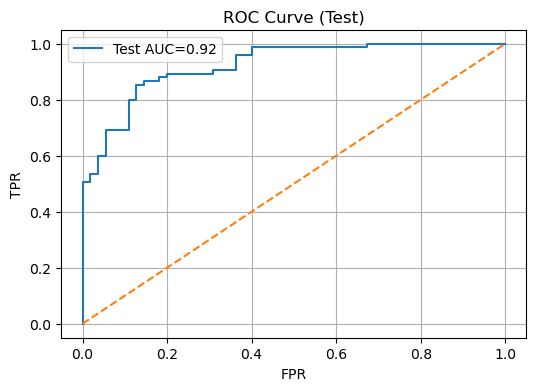

In [ ]:
# mlp_kfold_evaluation.py
# Fusion Embedding 기반 MLP 학습 및 평가 (k-Fold + Test 평가, Jupyter 환경용)

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_curve, auc
)
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler

# ▪ 설정
DATA_ROOT       = Path("embbeding_data")
AGG_METHOD      = "max"  # "mean" / "max" / "flatten"
DEVICE          = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE      = 64
LR              = 1e-4
WEIGHT_DECAY    = 1e-4
RETRAIN_EPOCHS  = 50
EARLY_STOP      = 5
N_FOLDS         = 5
SAVE_DIR        = Path("fusion_images"); SAVE_DIR.mkdir(exist_ok=True)

def load_split_aligned(split, model):
    base = DATA_ROOT / model / split
    emb  = np.load(base / "embeddings.npy")
    lbl  = np.load(base / "labels.npy").ravel()
    ids  = np.load(base / "ids.npy", allow_pickle=True).ravel()
    return emb, lbl, ids

def reduce_stgcn(arr):
    if AGG_METHOD == "mean":   return np.nanmean(arr, axis=1)
    if AGG_METHOD == "max":    return np.nanmax(arr, axis=1)
    if AGG_METHOD == "flatten":return arr.reshape(arr.shape[0], -1)
    raise ValueError

def align_by_ids(emb1, ids1, emb2, ids2):
    idx_map = {id_: i for i, id_ in enumerate(ids2)}
    idxs = [idx_map[id_] for id_ in ids1]
    return emb2[idxs]

# ▪ Split 별 TS/ST 로드 및 정렬
X_ts_tr, y_tr, ids_ts_tr = load_split_aligned("train",   "timesformer")
X_st_tr, _,    ids_st_tr = load_split_aligned("train",   "stgcnpp")
X_ts_va, y_va, ids_ts_va = load_split_aligned("valid",   "timesformer")
X_st_va, _,    ids_st_va = load_split_aligned("valid",   "stgcnpp")
X_ts_te, y_te, ids_ts_te = load_split_aligned("test",    "timesformer")
X_st_te, _,    ids_st_te = load_split_aligned("test",    "stgcnpp")

X_st_tr = reduce_stgcn(align_by_ids(X_ts_tr, ids_ts_tr, X_st_tr, ids_st_tr))
X_st_va = reduce_stgcn(align_by_ids(X_ts_va, ids_ts_va, X_st_va, ids_st_va))
X_st_te = reduce_stgcn(align_by_ids(X_ts_te, ids_ts_te, X_st_te, ids_st_te))

X_tr_raw = np.concatenate([X_ts_tr, X_st_tr], axis=1).astype(np.float32)
X_va_raw = np.concatenate([X_ts_va, X_st_va], axis=1).astype(np.float32)
X_te_raw = np.concatenate([X_ts_te, X_st_te], axis=1).astype(np.float32)

# ▪ 정규화 (train+valid 기준으로 fit)
scaler = StandardScaler().fit(np.vstack([X_tr_raw, X_va_raw]))
X_tr_scaled = scaler.transform(X_tr_raw)
X_va_scaled = scaler.transform(X_va_raw)
X_te_scaled = scaler.transform(X_te_raw)

# ▪ train+valid 합치기 (KFold 대상)
X_trva = np.vstack([X_tr_scaled, X_va_scaled])
y_trva = np.concatenate([y_tr, y_va], axis=0)

# ▪ 모델 정의
class HeadMLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 2)
        )
    def forward(self, x):
        return self.net(x)

def train_mlp(X, y):
    model = HeadMLP(X.shape[1]).to(DEVICE)
    opt   = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    crit  = nn.CrossEntropyLoss(label_smoothing=0.1)
    ds = TensorDataset(torch.from_numpy(X), torch.from_numpy(y))
    dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    best_loss, patience = float('inf'), 0
    for epoch in range(1, RETRAIN_EPOCHS+1):
        model.train(); running = 0.0
        for xb, yb in dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad(); out = model(xb)
            loss = crit(out, yb); loss.backward(); opt.step()
            running += loss.item() * yb.size(0)
        avg = running / len(ds)
        if avg < best_loss:
            best_loss, patience = avg, 0
            best_state = model.state_dict()
        else:
            patience += 1
            if patience >= EARLY_STOP: break
    model.load_state_dict(best_state)
    return model

def evaluate(model, X, y, title):
    model.eval()
    with torch.no_grad():
        logits = model(torch.from_numpy(X).to(DEVICE))
        probs = torch.softmax(logits, 1)[:,1].cpu().numpy()
    preds = (probs > 0.5).astype(int)
    acc = accuracy_score(y, preds)
    fpr, tpr, _ = roc_curve(y, probs)
    auc_val = auc(fpr, tpr)
    print(f"{title} acc={acc:.4f}, auc={auc_val:.4f}")
    print("CM:\n", confusion_matrix(y, preds))
    print(classification_report(y, preds, digits=4))
    return probs, preds, fpr, tpr, auc_val, acc


# ▪ KFold 학습/평가
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
kf_aucs, kf_accs = [], []
for i, (train_idx, valid_idx) in enumerate(skf.split(X_trva, y_trva), 1):
    X_tr_fold, X_va_fold = X_trva[train_idx], X_trva[valid_idx]
    y_tr_fold, y_va_fold = y_trva[train_idx], y_trva[valid_idx]
    model = train_mlp(X_tr_fold, y_tr_fold)
    probs, preds, fpr, tpr, auc_val, acc_val = evaluate(model, X_va_fold, y_va_fold, f"[KFold-{i}] Valid")
    # fold별 시각화 (이름을 다르게!)
    visualize_all(probs, y_va_fold, preds, fpr, tpr, auc_val, name=f"KFold{i}_Valid", subdir=f"KFold{i}_Valid")
    kf_aucs.append(auc_val)
    kf_accs.append(acc_val)

print(f"\n[KFold] 평균 AUC: {np.mean(kf_aucs):.4f} / 평균 Acc: {np.mean(kf_accs):.4f}")

# ▪ 최종 test set 전체 학습 후 평가
final_model = train_mlp(X_trva, y_trva)
probs_te, preds_te, fpr_te, tpr_te, auc_te, acc_te = evaluate(final_model, X_te_scaled, y_te, "[Test]")

# ▪ 시각화
visualize_all(probs_te, y_te, preds_te, fpr_te, tpr_te, auc_te, name="Test", subdir="Test")


# ▪ 시각화 저장
plt.figure(figsize=(6,4))
plt.plot(fpr_te, tpr_te, label=f"Test AUC={auc_te:.2f}")
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curve (Test)")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.grid()
plt.savefig(SAVE_DIR/"roc_test_only.png")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path
import os

BASE_DIR = Path("fusion_images")

def ensure_dir(path):
    Path(path).mkdir(exist_ok=True, parents=True)

def plot_roc(fpr, tpr, auc_val, name="Test", subdir="Test"):
    out_dir = BASE_DIR / subdir
    ensure_dir(out_dir)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"{name} AUC={auc_val:.2f}")
    plt.plot([0,1],[0,1],'--',color='grey')
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title(f"ROC Curve ({name})")
    plt.legend(); plt.grid(True)
    plt.tight_layout()
    plt.savefig(out_dir / f"roc_{name.lower()}.png")
    plt.close()

def plot_pr(y_true, probs, name="Test", subdir="Test"):
    out_dir = BASE_DIR / subdir
    ensure_dir(out_dir)
    precision, recall, _ = precision_recall_curve(y_true, probs)
    plt.figure(figsize=(6,4))
    plt.plot(recall, precision, label=f"{name} PR Curve")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve ({name})")
    plt.legend(); plt.grid(True)
    plt.tight_layout()
    plt.savefig(out_dir / f"pr_{name.lower()}.png")
    plt.close()

def plot_confmat(y_true, preds, name="Test", subdir="Test"):
    out_dir = BASE_DIR / subdir
    ensure_dir(out_dir)
    cm = confusion_matrix(y_true, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix ({name})")
    plt.tight_layout()
    plt.savefig(out_dir / f"confmat_{name.lower()}.png")
    plt.close()

def plot_histogram(probs, y_true, name="Test", subdir="Test"):
    out_dir = BASE_DIR / subdir
    ensure_dir(out_dir)
    plt.figure(figsize=(7,4))
    plt.hist(probs[y_true==0], bins=30, alpha=0.5, label="False (0)")
    plt.hist(probs[y_true==1], bins=30, alpha=0.5, label="True (1)")
    plt.xlabel("Predicted Probability"); plt.ylabel("Count")
    plt.title(f"Predicted Probability Histogram ({name})")
    plt.legend(); plt.tight_layout()
    plt.savefig(out_dir / f"hist_{name.lower()}.png")
    plt.close()

def visualize_all(probs, y_true, preds, fpr, tpr, auc_val, name="Test", subdir="Test"):
    plot_roc(fpr, tpr, auc_val, name, subdir)
    plot_pr(y_true, probs, name, subdir)
    plot_confmat(y_true, preds, name, subdir)
    plot_histogram(probs, y_true, name, subdir)
